Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

Following: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4 & https://github.com/practical-nlp/practical-nlp-code/blob/master/Ch4/02_Doc2Vec_Example.ipynb

In [35]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from string import punctuation
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument

### Get the data

In [4]:
data_fp = 'DATAPATH/complaints.csv'
if not os.path.exists(data_fp):
    !wget -P DATAPATH https://files.consumerfinance.gov/ccdb/complaints.csv.zip
    !unzip DATAPATH/complaints.csv.zip

### Read the data

In [10]:
df = pd.read_csv(data_fp)
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
display(df.head())
# sort the indexes 
df.index = range(df.shape[0])

narrative  \
1   I contacted Ally on Friday XX/XX/XXXX after fa...   
4   I am a victim of Identity Theft & currently ha...   
6   Hello This complaint is against the three cred...   
12  Dear XXXX, US Bank uses overdrafts in every wa...   
15  Two accounts are still on my credit history af...   

                                              Product  
1                               Vehicle loan or lease  
4   Credit reporting, credit repair services, or o...  
6   Credit reporting, credit repair services, or o...  
12                        Checking or savings account  
15  Credit reporting, credit repair services, or o...

### EDA

Number of words in corpus: 150113752


/home/rachel/miniconda3/envs/nlp-genism/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


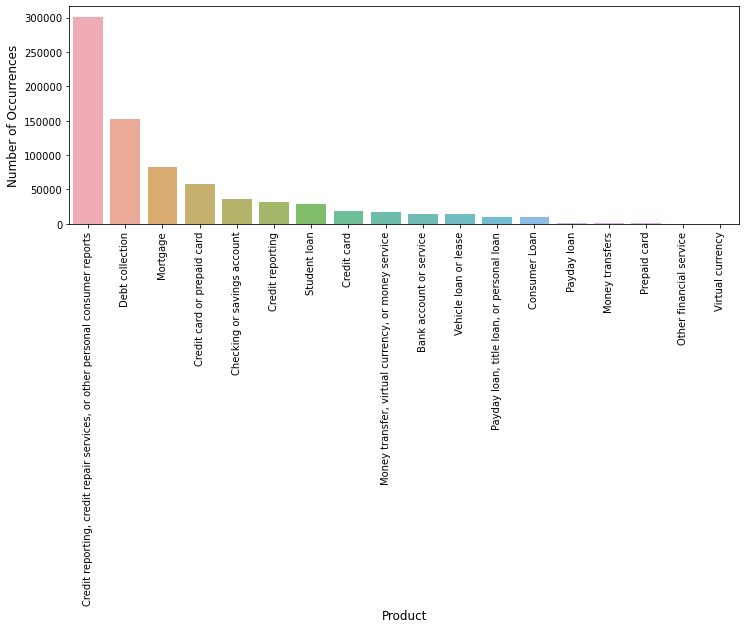

In [12]:
print(f'Number of words in corpus: {df["narrative"].apply(lambda x: len(x.split(" "))).sum()}')
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [17]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_complaint(0)
print('\n')
print_complaint(20)

I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. 

She advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. 

With this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several questions and advised me that a one or two month  extension/deffered payment could be done however partial payment is needed! WHAT? She advised me {$230

### Cleaning Text

In [52]:
def cleanText(text):
#     text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('//', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

### Pre-processing

In [56]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
# train, test = train_test_split(df.sample(50, random_state=42), test_size=0.3, random_state=42) 
mystopwords = set(stopwords.words("english"))

def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        #Nested function that removes stopwords and digits from a list of tokens
        return [token for token in tokens if token not in mystopwords and not token.isdigit() 
                and token not in punctuation]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return [remove_stops_digits(nltk.word_tokenize(texts))]

train_tagged = train.apply(
    lambda r: TaggedDocument(words=preprocess_corpus(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=preprocess_corpus(r['narrative']), tags=[r.Product]), axis=1)

In [57]:
train_tagged.values[1]

TaggedDocument(words=[['attn', 'collections', 'dept', 'submitting', 'complaint', 'reference', 'company', 'knowingly', 'reporting', 'inaccurate', 'data', 'credit', 'profile', 'affected', 'penalties', 'preventing', 'creditworthiness', 'due', 'companies', 'demand', 'proof', 'purchasing', 'agreement', 'valid', 'authorization/', 'proof', 'alleged', 'debt', 'reporting', 'without', 'valid', 'proper', 'disclosure', 'requirements', 'direct', 'violation', 'consumer', 'rights', 'legally', 'requested', 'description', 'details', 'verification', 'process', 'used', 'verify', 'alleged', 'account', 'federal', 'law', 'requires', 'respond', 'thirty', 'days', 'failure', 'comply', 'federal', 'regulations', 'ftc', 'u.s', 'c41', 'et', 'esq', 'maintaining', 'careful', 'record', 'communication', 'company', 'thank', 'look', 'forward', 'resolving', 'epeditiously']], tags=['Credit reporting, credit repair services, or other personal consumer reports'])

### Feature Engineering; train a Doc2Vec model
Distributed Bag of Words (DBOW)

DBOW is the doc2vec model analogous to Skip-gram model in word2vec.

The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

- `vector_size`: the dimensionality of the learned embeddings
- `alpha` is the learning rate
- `min_count` is the minimum frequency of words that remain in vocabulary
- `dm` stands for distributed memory, is one of the representation learners implemented in Doc2vec (the other is dbow, or distributed bag of words)
- `epochs` are the number of training iterations

In [ ]:
%%time
cores = multiprocessing.cpu_count()

# Building a Vocabulary
model = Doc2Vec(vector_size=300, alpha=0.025, min_count=5, dm=1, epochs=100, workers=cores)
model.build_vocab([x for x in tqdm(train_tagged.values)])
model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)
model.save("d2v.model")
print("Model Saved")


# model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

# # train a doc2vec model
# for epoch in range(30):
#     model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha
    
# # Building the Final Vector Feature for the Classifier
# def vec_for_learning(model, tagged_docs):
#     sents = tagged_docs.values
#     targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
#     return targets, regressors

### Model training

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

### Evaluate model

In [ ]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))